In [1]:
# this sets up basic packages
import numpy as np
import pandas as pd
import astropy.units as u
import astropy.cosmology.units as cu

# this sets up matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# this sets up astropy
from astropy.io import fits
from astropy.wcs import WCS
from astropy.wcs.utils import pixel_to_skycoord, skycoord_to_pixel
from astropy.utils.data import get_pkg_data_filename
from astropy.coordinates import SkyCoord, Angle, match_coordinates_sky, Distance
from astropy.cosmology import Planck15 as cosmo

from astropy.nddata import Cutout2D
from regions import PixCoord, Regions, CircleSkyRegion, CirclePixelRegion

from astropy.visualization import make_lupton_rgb

In [2]:
# this is the name of the catalog file compiled by Hollis
large_catalog = '/Users/ngbinh/Downloads/COSMOS-Web_supercatalog_v0.7.fits'

In [3]:
# this opens the HDU list of the .fits files and asks for the information within. SCI is what we'll use
hdu_list = fits.open(large_catalog)
hdu_list.info()

# this saves the WCS setting to be used later
wcs = WCS(hdu_list[1].header)

Filename: /Users/ngbinh/Downloads/COSMOS-Web_supercatalog_v0.7.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1                1 BinTableHDU    802   913253R x 155C   [K, D, D, 3A, D, 4A, L, D, D, D, D, D, D, D, D, 5D, 5D, 5D, L, D, D, D, D, D, D, D, D, 5D, 5D, 5D, L, D, D, D, D, D, D, D, D, 5D, 5D, 5D, L, D, D, D, D, D, D, D, D, 5D, 5D, 5D, L, D, D, D, D, D, D, D, D, 5D, 5D, 5D, L, D, D, D, D, D, D, D, D, 5D, 5D, 5D, L, K, E, E, K, L, K, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, L, K, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D]   


In [4]:
# this gets the data of the catalog. "cat" stands for catalog!
cat_data = hdu_list[1].data

In [5]:
# closes the data file
hdu_list.close()

In [6]:
# get all the essential info for comparison from the previously opened catalog
ra = cat_data['ra']
dec = cat_data['dec']
tile = cat_data['tile']
z_spec = cat_data['z_spec']

In [7]:
# now read in the RAs and Decs of our 9 galaxies to match them to Hollis's table
info = np.genfromtxt('basic_data.txt', delimiter=' ', dtype=['U15', '<f8','<f8', '<f8'])
print(info)

[('Hong', 150.06149 , 2.37868  , 3.715)
 ('Bach-Dang', 150.11256 , 2.3765266, 2.474)
 ('Thu-Bon', 150.06671 , 2.3823645, 3.715)
 ('Gianh', 150.08728 , 2.3960431, 3.782)
 ('Ben-Hai', 150.43732 , 2.46392  , 3.336)
 ('Tien', 150.45459 , 2.455994 , 3.757)
 ('Hau', 150.4612  , 2.429547 , 4.673)
 ('Dong-Nai', 150.106932, 2.377961 , 4.57 )
 ('Saigon', 150.108873, 2.330539 , 3.238)]


In [8]:
# now we find the indices of our 9 galaxies in Hollis's table and locate the tiles they're in

### create an empty array to fill things in
galaxy_idx = np.zeros(np.size(info), dtype=int)
galaxy_ra = np.zeros(np.size(info), dtype=float)
galaxy_dec = np.zeros(np.size(info), dtype=float)

for i in range(np.size(info)):
    ### locate the index of the galaxy in question by matching RA and Dec
    ### the 1e-4 difference is to account for the fact that the RA and Dec are later rounded (I think?)
    ra_idx = np.where(np.abs(ra - info[i][1]) < 1e-4)
    dec_idx = np.where(np.abs(dec - info[i][2]) < 1e-4)
    idx = np.intersect1d(ra_idx, dec_idx)

    ### save the index into galaxy_idx
    galaxy_idx[i] = idx[0]

    ### save the more detailed ra and dec into separate arrays
    galaxy_ra[i] = ra[idx[0]]
    galaxy_dec[i] = dec[idx[0]]

In [9]:
# locate the tiles that our galaxies are in
our_tiles = tile[galaxy_idx]
our_zs = z_spec[galaxy_idx]

In [10]:
nircam_bands = np.array(['f115w', 'f150w', 'f277w', 'f444w'])
how_many_bands = np.size(nircam_bands)

In [11]:
# next, we use 35 kpc (from Suess et al, 2023) and the redshifts of the 9 galaxies
# to find a corresponding search radius for neighbors around each of them.
d_Suess = 35 * u.kpc

In [12]:
# now get the redshifts from the data file
redshifts = np.zeros(np.size(info), dtype='float')
for i in range(np.size(info)):
    redshifts[i] = info[i][3]

In [13]:
from astropy.cosmology import Planck15 as cosmo

distances = cosmo.kpc_proper_per_arcmin(redshifts)
angular_sizes = (d_Suess / distances).to(u.arcsec)

In [14]:
print(angular_sizes)

[4.77437211 4.22164121 4.77437211 4.80782416 4.59011867 4.79531506
 5.26976031 5.21508875 4.54411388] arcsec


In [15]:
# now read in the RAs and Decs of our neighbors
colnames=['host_galaxy_name', 'neighbor_number', 'neighbor_ra', 'neighbor_dec', 'neighbor_z']
neigh = pd.read_csv('neighbor_data.txt', names=colnames, delimiter=' ')

Filename: /Volumes/LaCie/COSMOS_DATA/cweb_tiles/mosaic_nircam_f115w_COSMOS-Web_60mas_B7_sci.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  SCI           1 PrimaryHDU      73   (9600, 12455)   float32   
Filename: /Volumes/LaCie/COSMOS_DATA/cweb_tiles/mosaic_nircam_f150w_COSMOS-Web_60mas_B7_sci.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  SCI           1 PrimaryHDU      73   (9600, 12455)   float32   
Filename: /Volumes/LaCie/COSMOS_DATA/cweb_tiles/mosaic_nircam_f277w_COSMOS-Web_60mas_B7_sci.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  SCI           1 PrimaryHDU      73   (9600, 12455)   float32   
Filename: /Volumes/LaCie/COSMOS_DATA/cweb_tiles/mosaic_nircam_f444w_COSMOS-Web_60mas_B7_sci.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  SCI           1 PrimaryHDU      73   (9600, 12455)   float32   


Set DATE-AVG to '2023-09-07T08:08:39.516' from MJD-AVG.
Set DATE-END to '2024-01-06T13:45:27.595' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to     8.938284 from OBSGEO-[XYZ].
Set OBSGEO-H to 1696349812.184 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2023-09-02T04:30:47.638' from MJD-AVG.
Set DATE-END to '2024-01-06T14:20:21.225' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to     8.880441 from OBSGEO-[XYZ].
Set OBSGEO-H to 1689561270.072 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2023-08-27T10:47:09.482' from MJD-AVG.
Set DATE-END to '2024-01-06T13:45:27.595' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to     8.877923 from OBSGEO-[XYZ].
Set OBSGEO-H to 1689690570.898 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2023-08-24T20:33:34.974' from MJD-AVG.
Set DATE-END to '2024-01-06T14:20:21.289' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to     8.955753 from OBSGEO-[XYZ].
Set OBSGEO-H to 1686788846.143 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: /Volumes/LaCie/COSMOS_DATA/cweb_tiles/mosaic_nircam_f115w_COSMOS-Web_60mas_B7_sci.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  SCI           1 PrimaryHDU      73   (9600, 12455)   float32   
Filename: /Volumes/LaCie/COSMOS_DATA/cweb_tiles/mosaic_nircam_f150w_COSMOS-Web_60mas_B7_sci.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  SCI           1 PrimaryHDU      73   (9600, 12455)   float32   
Filename: /Volumes/LaCie/COSMOS_DATA/cweb_tiles/mosaic_nircam_f277w_COSMOS-Web_60mas_B7_sci.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  SCI           1 PrimaryHDU      73   (9600, 12455)   float32   
Filename: /Volumes/LaCie/COSMOS_DATA/cweb_tiles/mosaic_nircam_f444w_COSMOS-Web_60mas_B7_sci.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  SCI           1 PrimaryHDU      73   (9600, 12455)   float32   


Set DATE-AVG to '2023-09-07T08:08:39.516' from MJD-AVG.
Set DATE-END to '2024-01-06T13:45:27.595' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to     8.938284 from OBSGEO-[XYZ].
Set OBSGEO-H to 1696349812.184 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2023-09-02T04:30:47.638' from MJD-AVG.
Set DATE-END to '2024-01-06T14:20:21.225' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to     8.880441 from OBSGEO-[XYZ].
Set OBSGEO-H to 1689561270.072 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2023-08-27T10:47:09.482' from MJD-AVG.
Set DATE-END to '2024-01-06T13:45:27.595' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to     8.877923 from OBSGEO-[XYZ].
Set OBSGEO-H to 1689690570.898 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2023-08-24T20:33:34.974' from MJD-AVG.
Set DATE-END to '2024-01-06T14:20:21.289' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to     8.955753 from OBSGEO-[XYZ].
Set OBSGEO-H to 1686788846.143 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: /Volumes/LaCie/COSMOS_DATA/cweb_tiles/mosaic_nircam_f115w_COSMOS-Web_60mas_B7_sci.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  SCI           1 PrimaryHDU      73   (9600, 12455)   float32   
Filename: /Volumes/LaCie/COSMOS_DATA/cweb_tiles/mosaic_nircam_f150w_COSMOS-Web_60mas_B7_sci.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  SCI           1 PrimaryHDU      73   (9600, 12455)   float32   
Filename: /Volumes/LaCie/COSMOS_DATA/cweb_tiles/mosaic_nircam_f277w_COSMOS-Web_60mas_B7_sci.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  SCI           1 PrimaryHDU      73   (9600, 12455)   float32   
Filename: /Volumes/LaCie/COSMOS_DATA/cweb_tiles/mosaic_nircam_f444w_COSMOS-Web_60mas_B7_sci.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  SCI           1 PrimaryHDU      73   (9600, 12455)   float32   


Set DATE-AVG to '2023-09-07T08:08:39.516' from MJD-AVG.
Set DATE-END to '2024-01-06T13:45:27.595' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to     8.938284 from OBSGEO-[XYZ].
Set OBSGEO-H to 1696349812.184 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2023-09-02T04:30:47.638' from MJD-AVG.
Set DATE-END to '2024-01-06T14:20:21.225' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to     8.880441 from OBSGEO-[XYZ].
Set OBSGEO-H to 1689561270.072 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2023-08-27T10:47:09.482' from MJD-AVG.
Set DATE-END to '2024-01-06T13:45:27.595' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to     8.877923 from OBSGEO-[XYZ].
Set OBSGEO-H to 1689690570.898 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2023-08-24T20:33:34.974' from MJD-AVG.
Set DATE-END to '2024-01-06T14:20:21.289' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to     8.955753 from OBSGEO-[XYZ].
Set OBSGEO-H to 1686788846.143 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: /Volumes/LaCie/COSMOS_DATA/cweb_tiles/mosaic_nircam_f115w_COSMOS-Web_60mas_B7_sci.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  SCI           1 PrimaryHDU      73   (9600, 12455)   float32   
Filename: /Volumes/LaCie/COSMOS_DATA/cweb_tiles/mosaic_nircam_f150w_COSMOS-Web_60mas_B7_sci.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  SCI           1 PrimaryHDU      73   (9600, 12455)   float32   
Filename: /Volumes/LaCie/COSMOS_DATA/cweb_tiles/mosaic_nircam_f277w_COSMOS-Web_60mas_B7_sci.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  SCI           1 PrimaryHDU      73   (9600, 12455)   float32   
Filename: /Volumes/LaCie/COSMOS_DATA/cweb_tiles/mosaic_nircam_f444w_COSMOS-Web_60mas_B7_sci.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  SCI           1 PrimaryHDU      73   (9600, 12455)   float32   


Set DATE-AVG to '2023-09-07T08:08:39.516' from MJD-AVG.
Set DATE-END to '2024-01-06T13:45:27.595' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to     8.938284 from OBSGEO-[XYZ].
Set OBSGEO-H to 1696349812.184 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2023-09-02T04:30:47.638' from MJD-AVG.
Set DATE-END to '2024-01-06T14:20:21.225' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to     8.880441 from OBSGEO-[XYZ].
Set OBSGEO-H to 1689561270.072 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2023-08-27T10:47:09.482' from MJD-AVG.
Set DATE-END to '2024-01-06T13:45:27.595' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to     8.877923 from OBSGEO-[XYZ].
Set OBSGEO-H to 1689690570.898 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2023-08-24T20:33:34.974' from MJD-AVG.
Set DATE-END to '2024-01-06T14:20:21.289' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to     8.955753 from OBSGEO-[XYZ].
Set OBSGEO-H to 1686788846.143 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: /Volumes/LaCie/COSMOS_DATA/cweb_tiles/mosaic_nircam_f115w_COSMOS-Web_60mas_B4_sci.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  SCI           1 PrimaryHDU      73   (9600, 12455)   float32   
Filename: /Volumes/LaCie/COSMOS_DATA/cweb_tiles/mosaic_nircam_f150w_COSMOS-Web_60mas_B4_sci.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  SCI           1 PrimaryHDU      73   (9600, 12455)   float32   
Filename: /Volumes/LaCie/COSMOS_DATA/cweb_tiles/mosaic_nircam_f277w_COSMOS-Web_60mas_B4_sci.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  SCI           1 PrimaryHDU      73   (9600, 12455)   float32   
Filename: /Volumes/LaCie/COSMOS_DATA/cweb_tiles/mosaic_nircam_f444w_COSMOS-Web_60mas_B4_sci.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  SCI           1 PrimaryHDU      73   (9600, 12455)   float32   


Set DATE-AVG to '2024-01-03T01:59:11.190' from MJD-AVG.
Set DATE-END to '2024-01-06T17:28:50.910' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to     9.012152 from OBSGEO-[XYZ].
Set OBSGEO-H to 1696582650.366 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2024-01-03T02:33:49.399' from MJD-AVG.
Set DATE-END to '2024-01-06T18:03:33.852' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to     8.962298 from OBSGEO-[XYZ].
Set OBSGEO-H to 1686149605.641 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2024-01-02T11:26:42.626' from MJD-AVG.
Set DATE-END to '2024-01-06T17:28:50.910' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to     9.002883 from OBSGEO-[XYZ].
Set OBSGEO-H to 1696586013.959 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2024-01-02T12:01:20.603' from MJD-AVG.
Set DATE-END to '2024-01-06T18:03:33.852' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to     8.998031 from OBSGEO-[XYZ].
Set OBSGEO-H to 1696584712.167 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: /Volumes/LaCie/COSMOS_DATA/cweb_tiles/mosaic_nircam_f115w_COSMOS-Web_60mas_B5_sci.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  SCI           1 PrimaryHDU      73   (9600, 12455)   float32   
Filename: /Volumes/LaCie/COSMOS_DATA/cweb_tiles/mosaic_nircam_f150w_COSMOS-Web_60mas_B5_sci.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  SCI           1 PrimaryHDU      73   (9600, 12455)   float32   
Filename: /Volumes/LaCie/COSMOS_DATA/cweb_tiles/mosaic_nircam_f277w_COSMOS-Web_60mas_B5_sci.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  SCI           1 PrimaryHDU      73   (9600, 12455)   float32   
Filename: /Volumes/LaCie/COSMOS_DATA/cweb_tiles/mosaic_nircam_f444w_COSMOS-Web_60mas_B5_sci.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  SCI           1 PrimaryHDU      73   (9600, 12455)   float32   


Set DATE-AVG to '2024-01-01T13:30:10.219' from MJD-AVG.
Set DATE-END to '2024-01-06T20:06:50.261' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to     8.888100 from OBSGEO-[XYZ].
Set OBSGEO-H to 1695630093.460 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2024-01-01T14:04:49.430' from MJD-AVG.
Set DATE-END to '2024-01-06T20:41:43.955' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to     8.887810 from OBSGEO-[XYZ].
Set OBSGEO-H to 1695623362.790 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2024-01-01T17:28:21.465' from MJD-AVG.
Set DATE-END to '2024-01-06T20:06:50.261' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to     9.002883 from OBSGEO-[XYZ].
Set OBSGEO-H to 1696586013.959 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2024-01-01T18:03:01.413' from MJD-AVG.
Set DATE-END to '2024-01-06T20:41:43.955' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to     9.004838 from OBSGEO-[XYZ].
Set OBSGEO-H to 1696585931.786 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: /Volumes/LaCie/COSMOS_DATA/cweb_tiles/mosaic_nircam_f115w_COSMOS-Web_60mas_B5_sci.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  SCI           1 PrimaryHDU      73   (9600, 12455)   float32   
Filename: /Volumes/LaCie/COSMOS_DATA/cweb_tiles/mosaic_nircam_f150w_COSMOS-Web_60mas_B5_sci.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  SCI           1 PrimaryHDU      73   (9600, 12455)   float32   
Filename: /Volumes/LaCie/COSMOS_DATA/cweb_tiles/mosaic_nircam_f277w_COSMOS-Web_60mas_B5_sci.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  SCI           1 PrimaryHDU      73   (9600, 12455)   float32   
Filename: /Volumes/LaCie/COSMOS_DATA/cweb_tiles/mosaic_nircam_f444w_COSMOS-Web_60mas_B5_sci.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  SCI           1 PrimaryHDU      73   (9600, 12455)   float32   


Set DATE-AVG to '2024-01-01T13:30:10.219' from MJD-AVG.
Set DATE-END to '2024-01-06T20:06:50.261' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to     8.888100 from OBSGEO-[XYZ].
Set OBSGEO-H to 1695630093.460 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2024-01-01T14:04:49.430' from MJD-AVG.
Set DATE-END to '2024-01-06T20:41:43.955' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to     8.887810 from OBSGEO-[XYZ].
Set OBSGEO-H to 1695623362.790 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2024-01-01T17:28:21.465' from MJD-AVG.
Set DATE-END to '2024-01-06T20:06:50.261' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to     9.002883 from OBSGEO-[XYZ].
Set OBSGEO-H to 1696586013.959 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2024-01-01T18:03:01.413' from MJD-AVG.
Set DATE-END to '2024-01-06T20:41:43.955' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to     9.004838 from OBSGEO-[XYZ].
Set OBSGEO-H to 1696585931.786 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: /Volumes/LaCie/COSMOS_DATA/cweb_tiles/mosaic_nircam_f115w_COSMOS-Web_60mas_B7_sci.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  SCI           1 PrimaryHDU      73   (9600, 12455)   float32   
Filename: /Volumes/LaCie/COSMOS_DATA/cweb_tiles/mosaic_nircam_f150w_COSMOS-Web_60mas_B7_sci.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  SCI           1 PrimaryHDU      73   (9600, 12455)   float32   
Filename: /Volumes/LaCie/COSMOS_DATA/cweb_tiles/mosaic_nircam_f277w_COSMOS-Web_60mas_B7_sci.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  SCI           1 PrimaryHDU      73   (9600, 12455)   float32   
Filename: /Volumes/LaCie/COSMOS_DATA/cweb_tiles/mosaic_nircam_f444w_COSMOS-Web_60mas_B7_sci.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  SCI           1 PrimaryHDU      73   (9600, 12455)   float32   


Set DATE-AVG to '2023-09-07T08:08:39.516' from MJD-AVG.
Set DATE-END to '2024-01-06T13:45:27.595' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to     8.938284 from OBSGEO-[XYZ].
Set OBSGEO-H to 1696349812.184 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2023-09-02T04:30:47.638' from MJD-AVG.
Set DATE-END to '2024-01-06T14:20:21.225' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to     8.880441 from OBSGEO-[XYZ].
Set OBSGEO-H to 1689561270.072 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2023-08-27T10:47:09.482' from MJD-AVG.
Set DATE-END to '2024-01-06T13:45:27.595' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to     8.877923 from OBSGEO-[XYZ].
Set OBSGEO-H to 1689690570.898 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2023-08-24T20:33:34.974' from MJD-AVG.
Set DATE-END to '2024-01-06T14:20:21.289' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to     8.955753 from OBSGEO-[XYZ].
Set OBSGEO-H to 1686788846.143 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: /Volumes/LaCie/COSMOS_DATA/cweb_tiles/mosaic_nircam_f115w_COSMOS-Web_60mas_B8_sci.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  SCI           1 PrimaryHDU      73   (9600, 12455)   float32   
Filename: /Volumes/LaCie/COSMOS_DATA/cweb_tiles/mosaic_nircam_f150w_COSMOS-Web_60mas_B8_sci.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  SCI           1 PrimaryHDU      73   (9600, 12455)   float32   
Filename: /Volumes/LaCie/COSMOS_DATA/cweb_tiles/mosaic_nircam_f277w_COSMOS-Web_60mas_B8_sci.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  SCI           1 PrimaryHDU      73   (9600, 12455)   float32   
Filename: /Volumes/LaCie/COSMOS_DATA/cweb_tiles/mosaic_nircam_f444w_COSMOS-Web_60mas_B8_sci.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  SCI           1 PrimaryHDU      73   (9600, 12455)   float32   


Set DATE-AVG to '2023-12-15T06:24:31.291' from MJD-AVG.
Set DATE-END to '2024-01-06T18:30:50.458' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to     8.938284 from OBSGEO-[XYZ].
Set OBSGEO-H to 1696349812.184 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2023-12-17T00:49:53.682' from MJD-AVG.
Set DATE-END to '2024-01-06T19:05:22.649' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to     8.941421 from OBSGEO-[XYZ].
Set OBSGEO-H to 1696374654.240 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2023-12-04T06:52:06.528' from MJD-AVG.
Set DATE-END to '2024-01-06T18:30:50.458' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to     8.940522 from OBSGEO-[XYZ].
Set OBSGEO-H to 1696367709.229 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2023-12-06T20:13:01.371' from MJD-AVG.
Set DATE-END to '2024-01-06T19:05:22.649' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to     8.955753 from OBSGEO-[XYZ].
Set OBSGEO-H to 1686788846.143 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


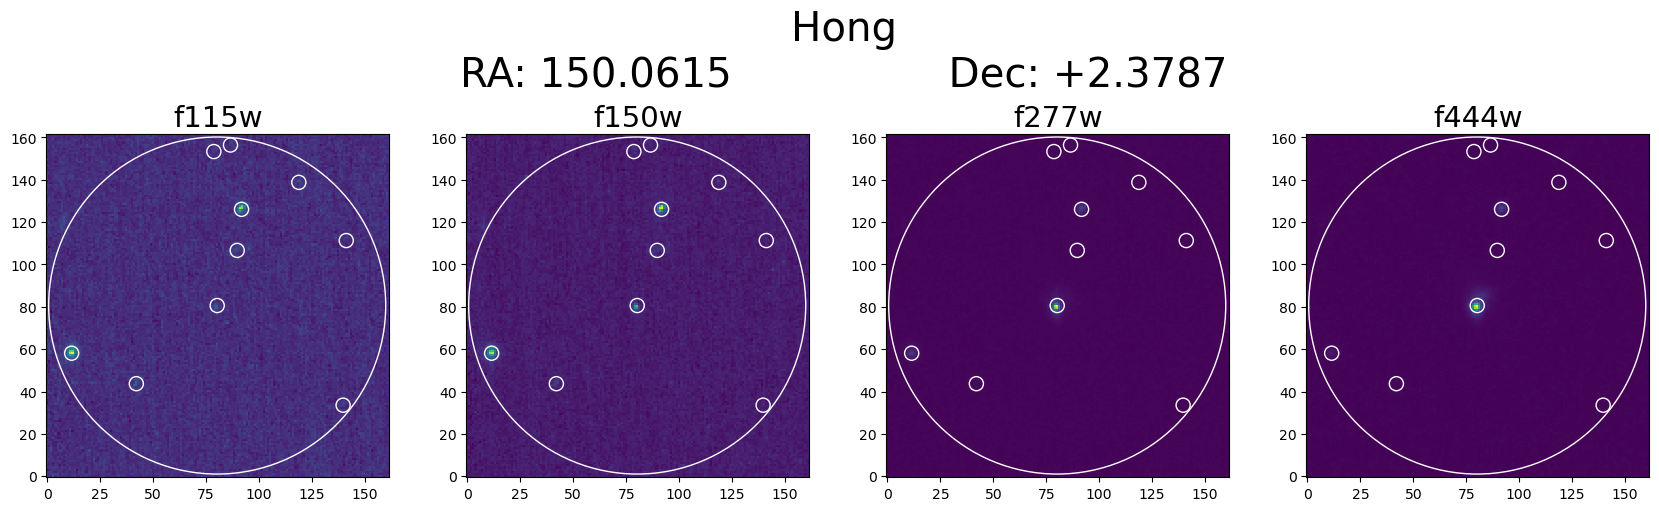

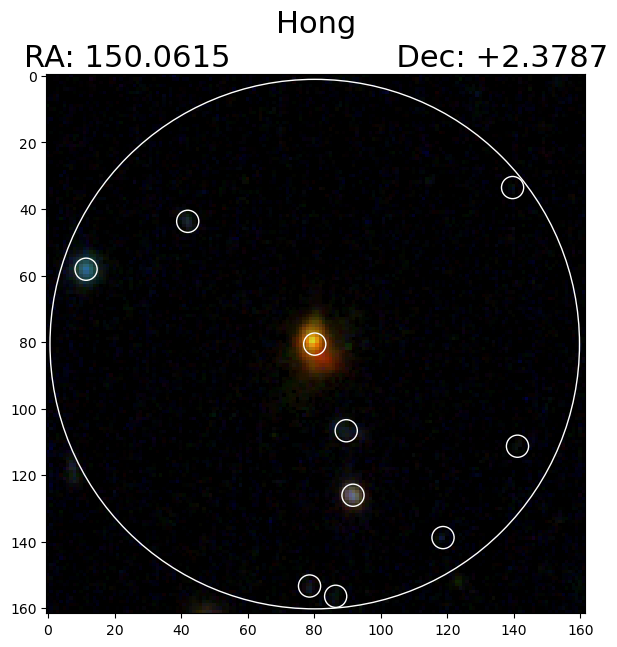

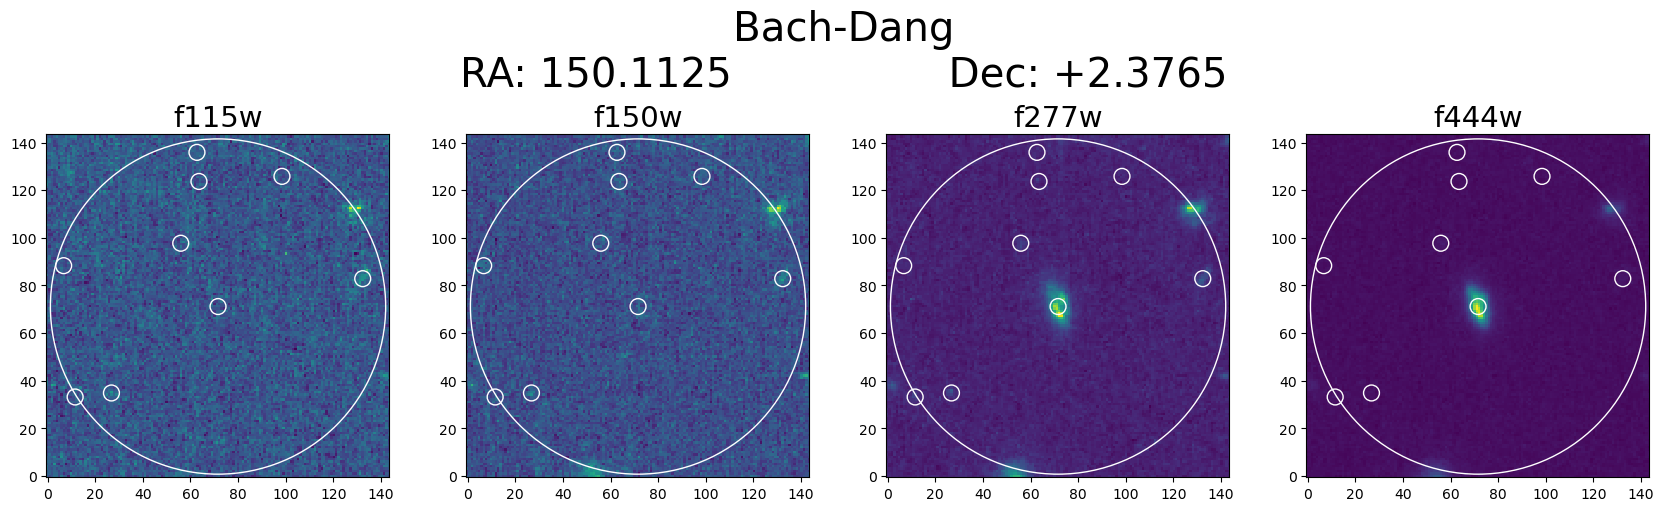

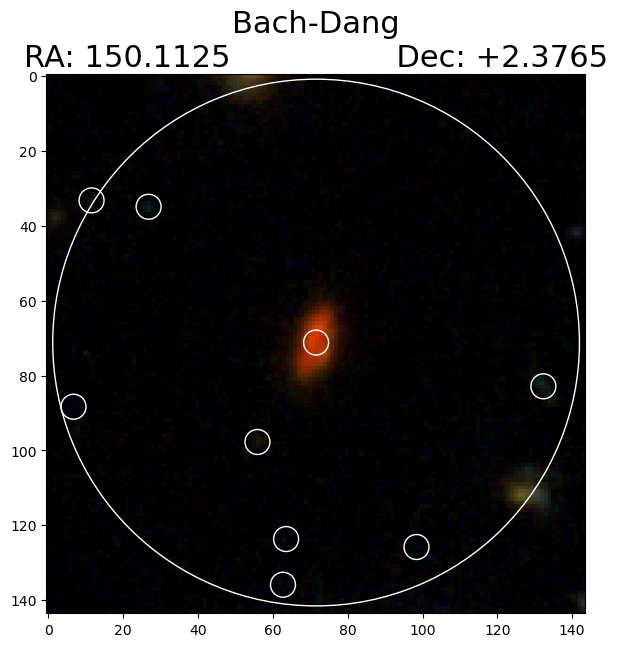

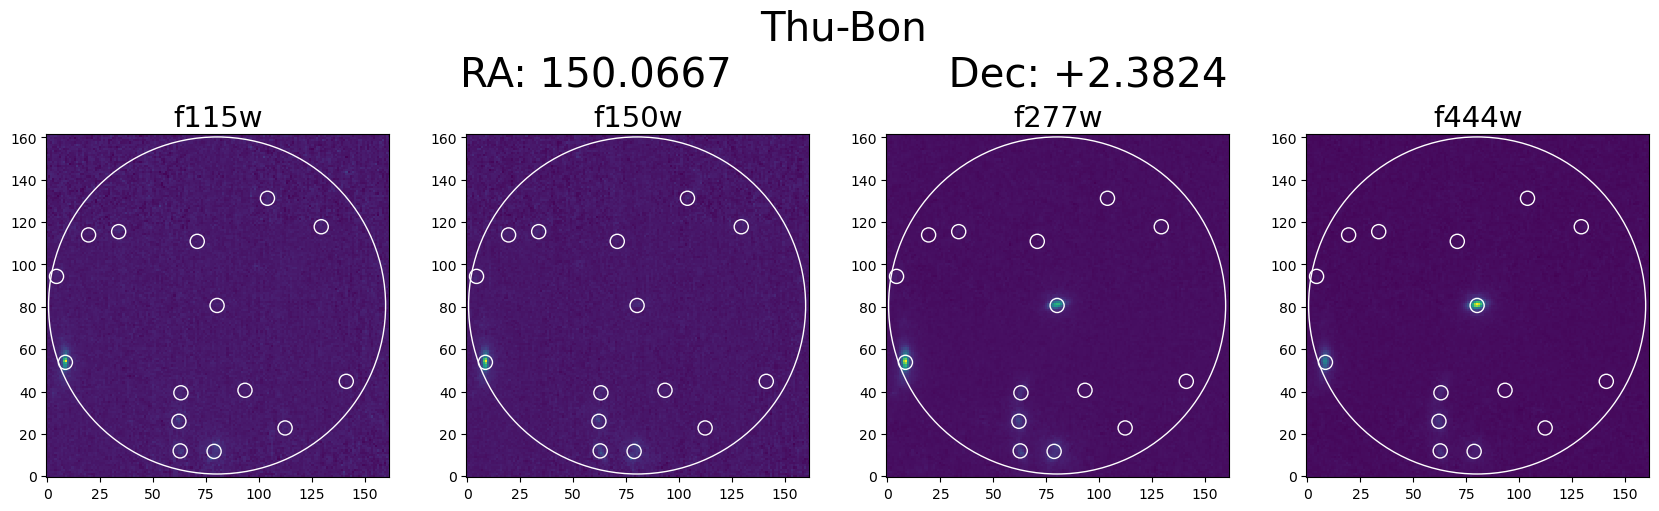

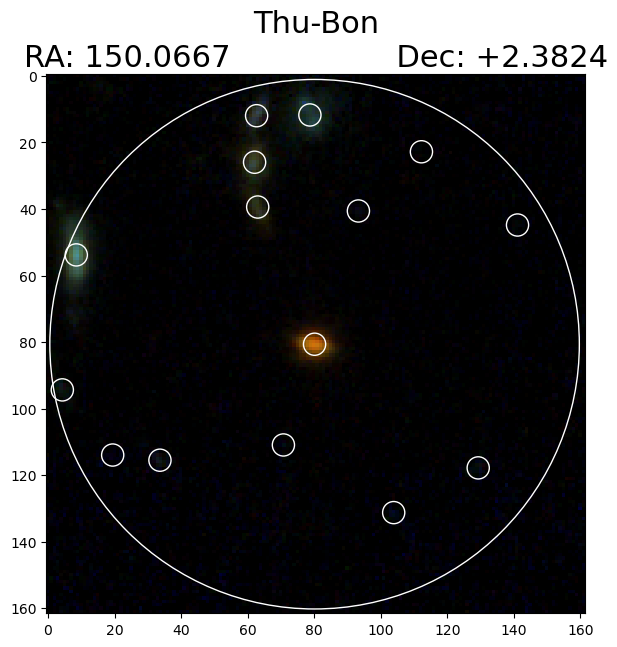

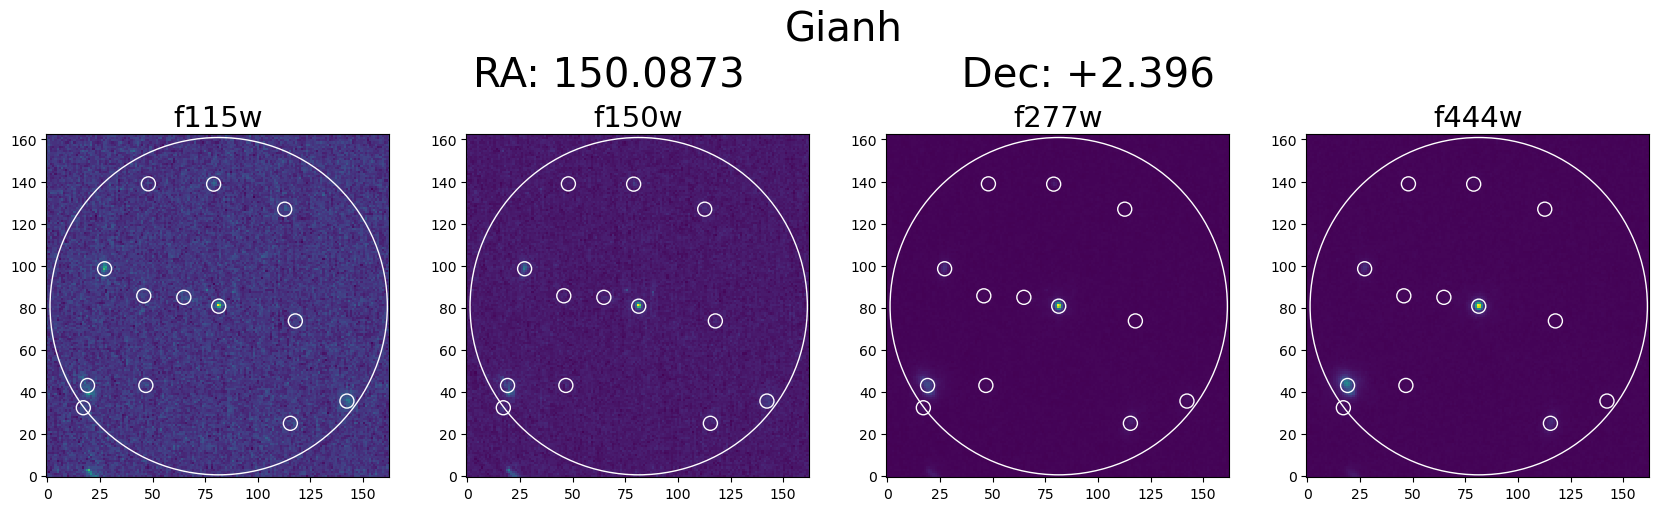

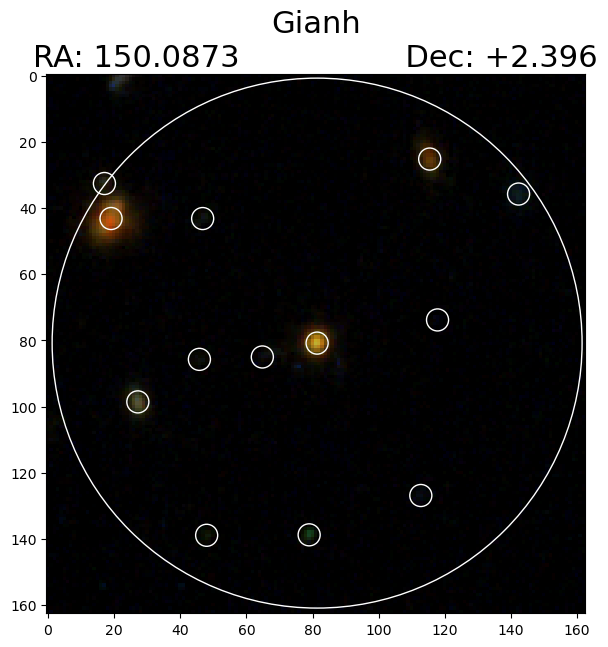

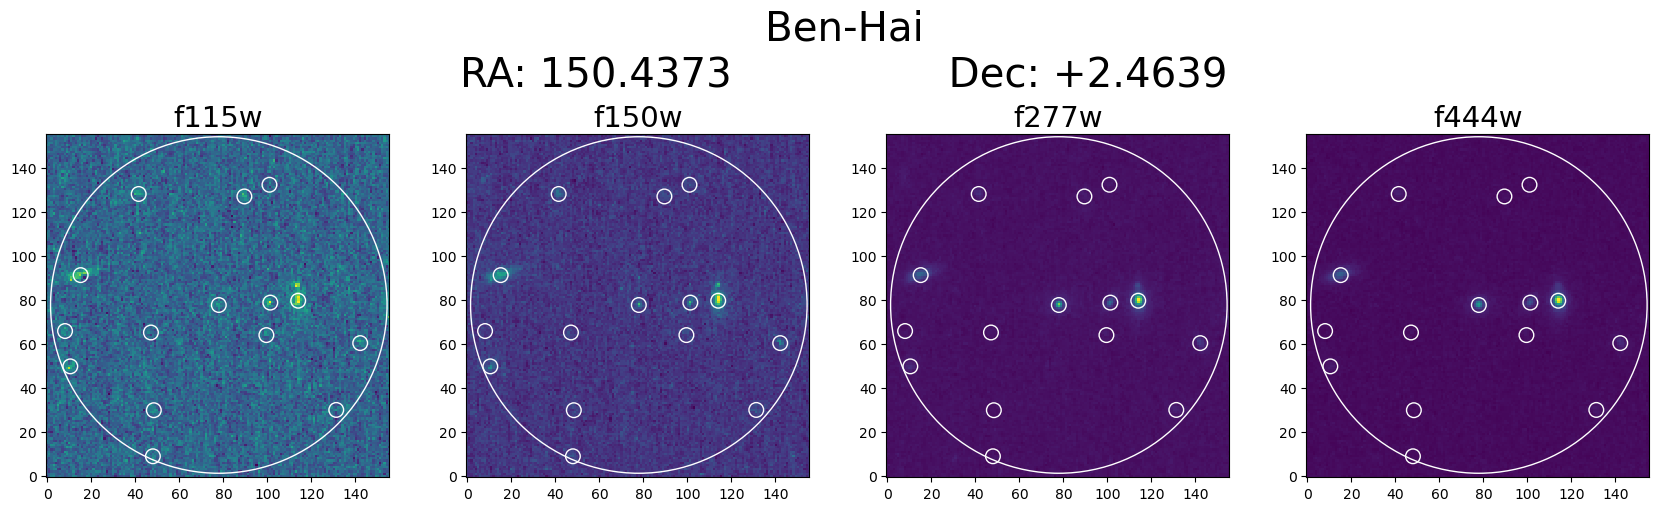

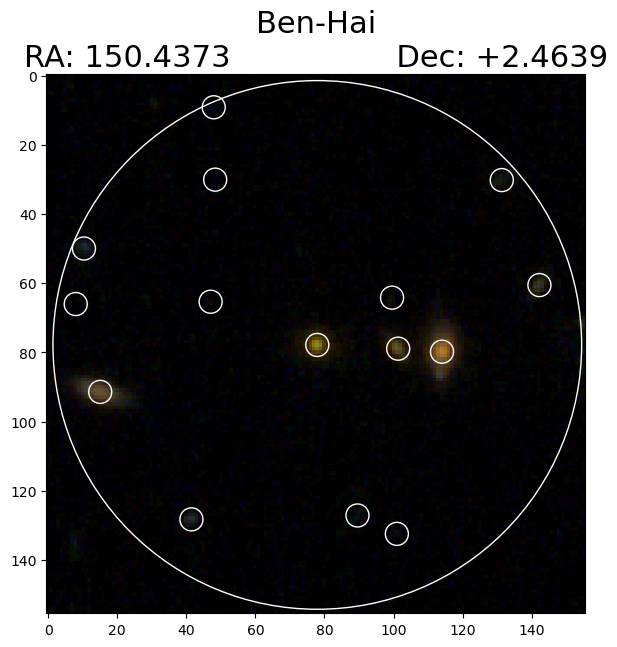

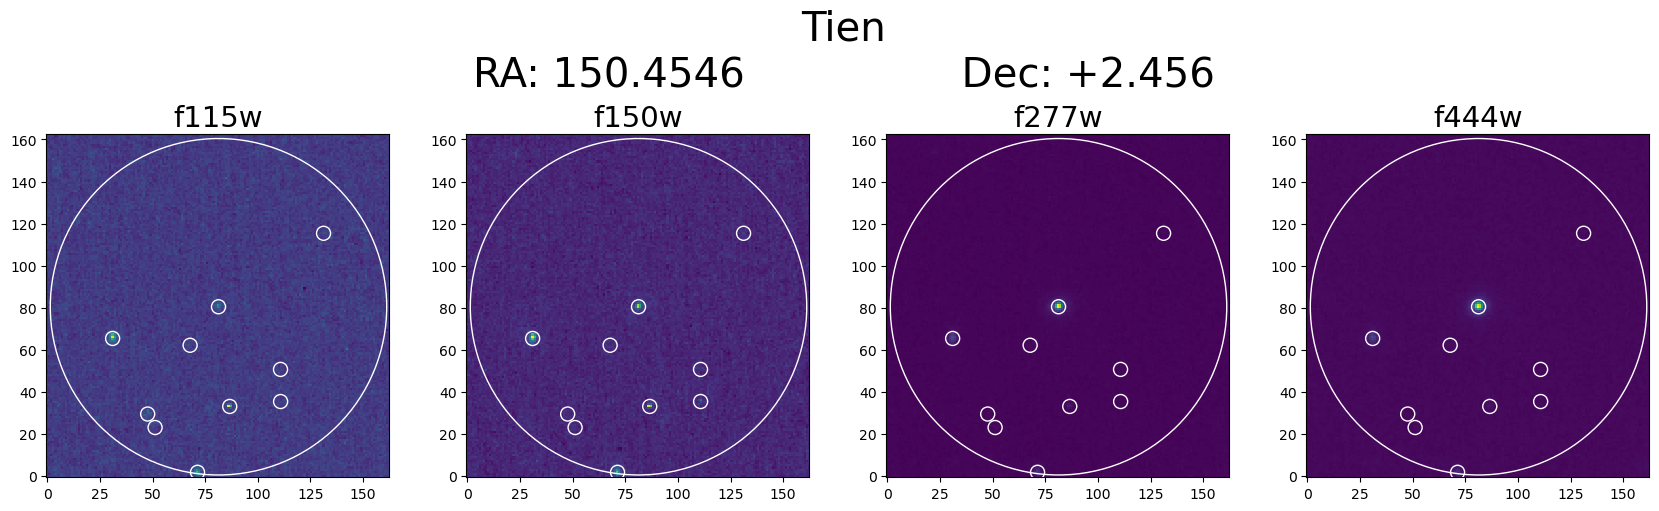

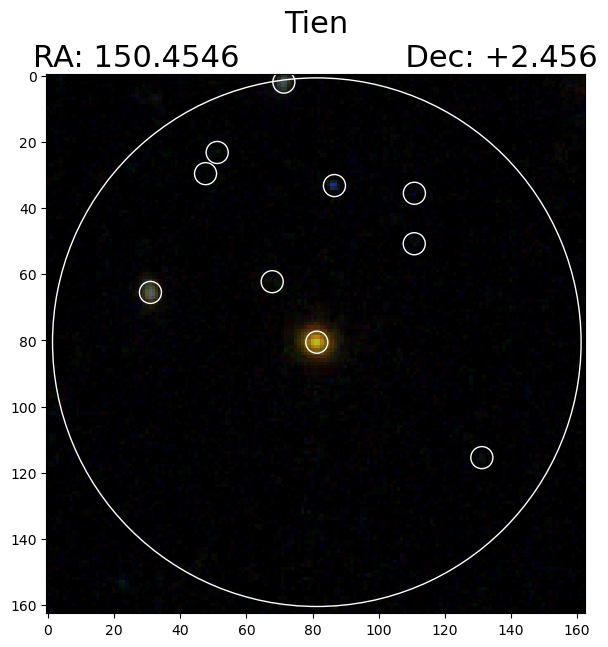

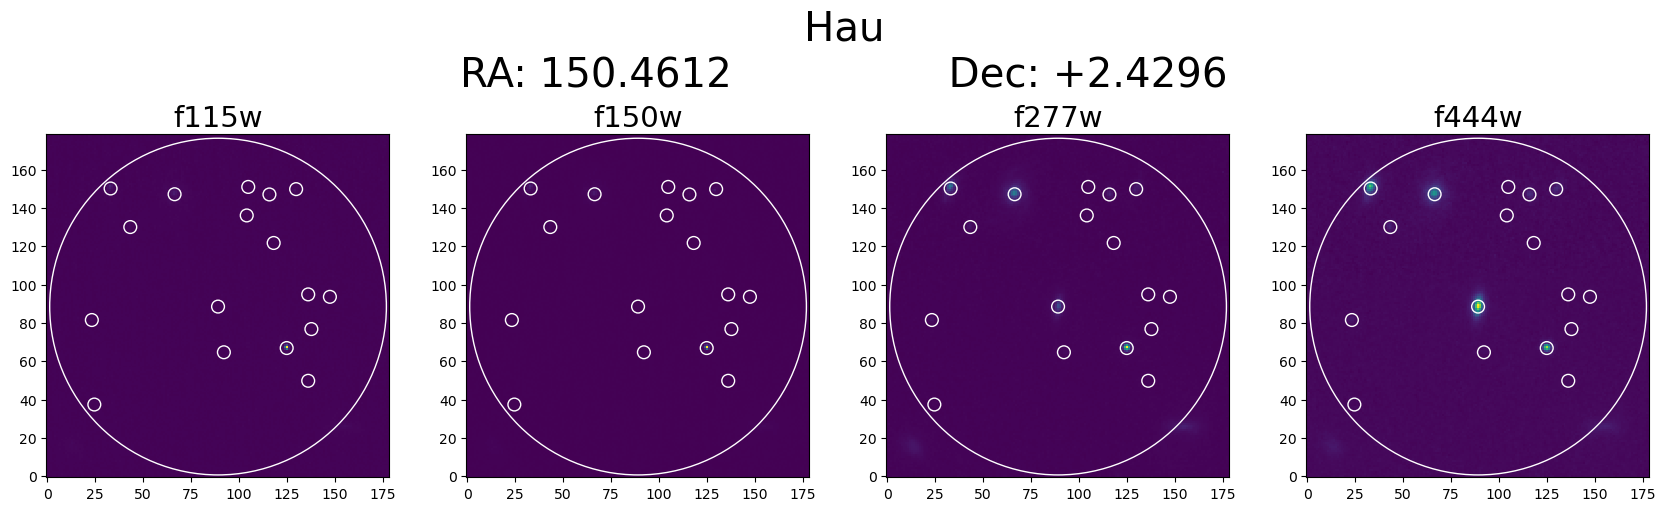

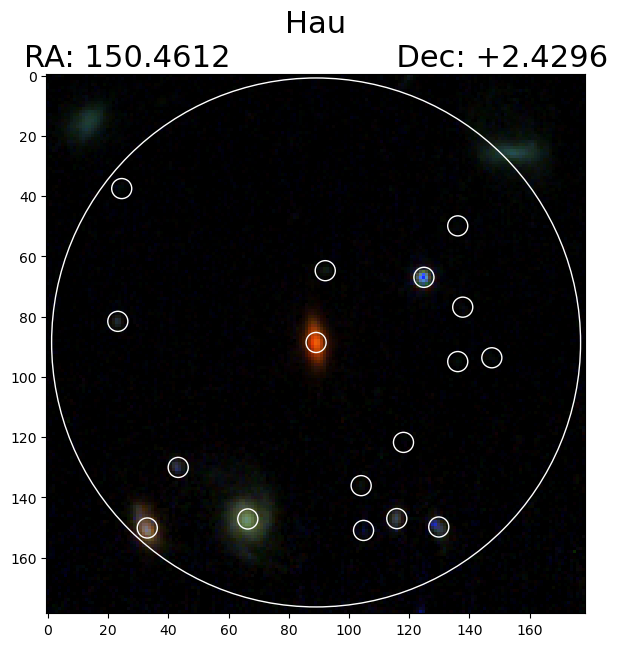

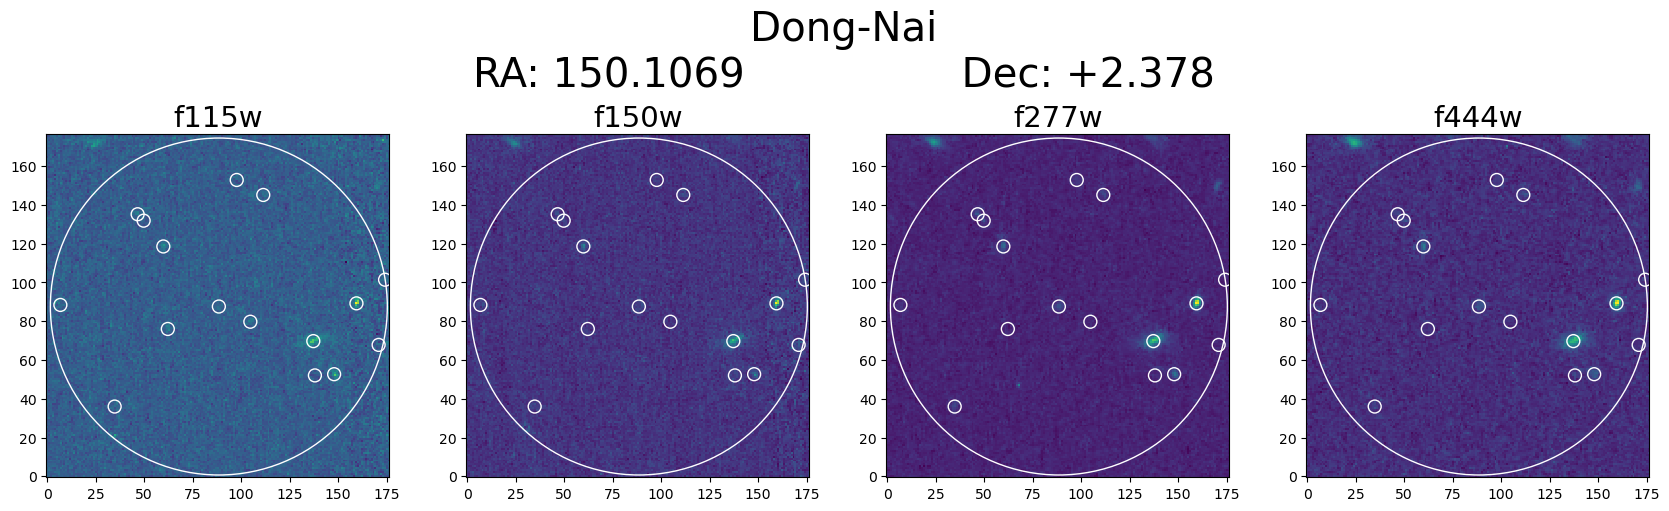

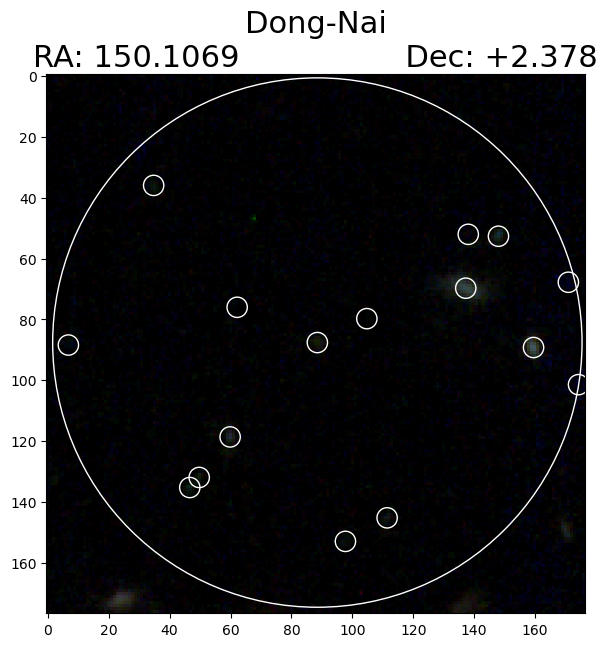

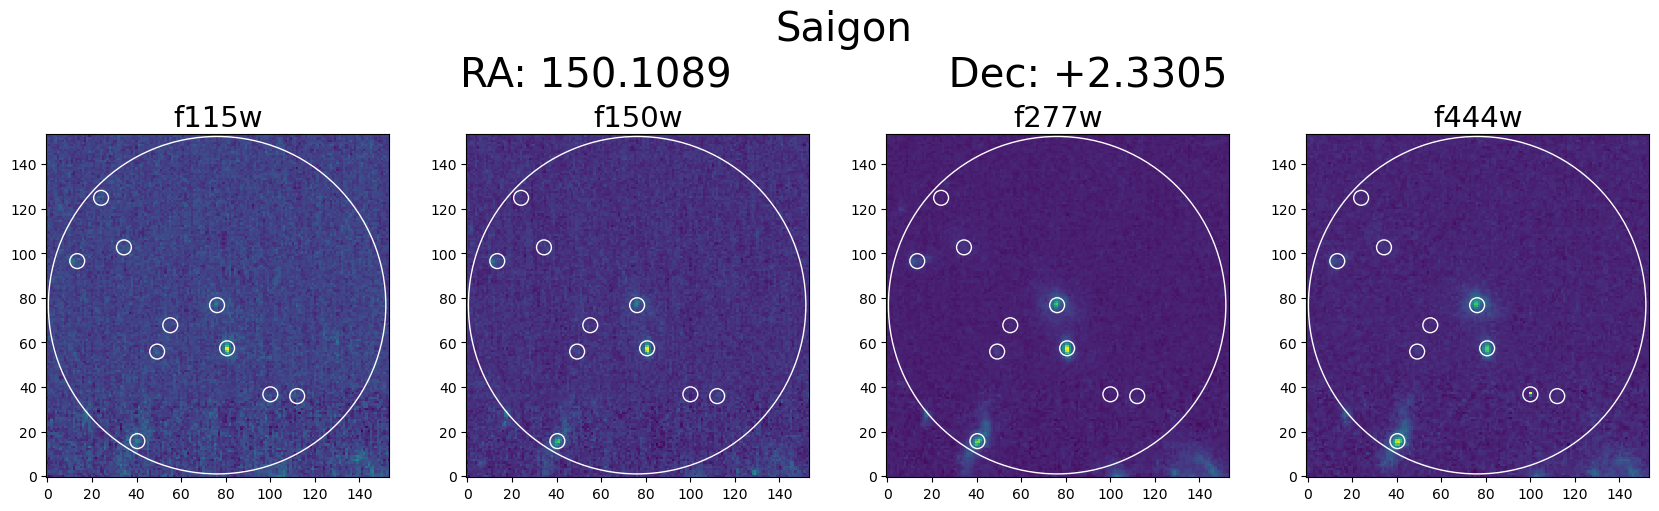

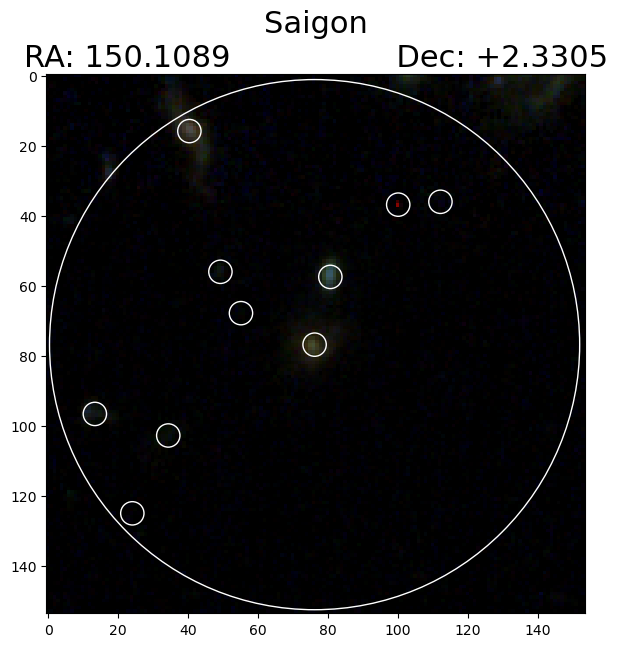

In [34]:
### this loops over each of the galaxies we're looking for
for our_galaxy in range(np.size(info)):
    ### this saves the name of our galaxy so it's easier to make plots
    galaxy_name = info[our_galaxy][0]

    ### this selects a search radius for our galaxy based on the angular size
    search_radius = angular_sizes[our_galaxy]

    ### this picks out the tile where our galaxy can be found in the image
    tile_search = our_tiles[our_galaxy]

    ### this creates a matplotlib figure in advance for the loop after
    fig, axes = plt.subplots(1,how_many_bands, constrained_layout=True, figsize=(4.2*how_many_bands, 5))

    ### this creates an empty list to append RGB band datas into
    ### the RGB bands are: F444W (red), F277W (green) and F150W (blue)
    ### note that due to the order in nircam_bands, the order here will be flipped as BGR
    BGR_bands = []

    ### now, we make the aperture for each of the neighbors
    # this reads in the RAs and Decs of all the neighbor around each galaxy
    neigh_ra = np.array(neigh[neigh['host_galaxy_name']==galaxy_name]['neighbor_ra'])
    neigh_dec = np.array(neigh[neigh['host_galaxy_name']==galaxy_name]['neighbor_dec'])
    number_of_nbrs = np.size(neigh_ra)

    ### this loops over all the available bands for NIRCam
    for i in range(how_many_bands):
        # this selects one of the bands to work with
        band = nircam_bands[i]
    
        # this creates a path to lead the code to our fits file
        our_file = '/Volumes/LaCie/COSMOS_DATA/cweb_tiles/mosaic_nircam_' + band + '_COSMOS-Web_60mas_' + tile_search + '_sci.fits'
    
        # this opens the fits file that matches the path above
        file = fits.open(our_file)
        file.info()
        
        # this saves the WCS setting from the fits file to be used later
        our_wcs = WCS(file[0].header)
    
        # this gets the data of the catalog
        our_data = file[0].data
    
        # this closes the file to save up memory
        file.close()
        
        # this sets a centering position based on the RA and Dec of our galaxy
        position = SkyCoord(ra=galaxy_ra[our_galaxy]*u.degree, dec=galaxy_dec[our_galaxy]*u.degree)
        
        # this creates a cutout. the additional factor of 2.04 is to make sure that the region is shown.
        cutout = Cutout2D(our_data, position, size=search_radius*2.04, wcs=our_wcs)

        # this saves the arrays if they're RGB bands (the latter three bands in our array)
        if i > 0:
            BGR_bands.append(cutout.data)
        
        # this plots our images
        ax = axes[i]
        ax.imshow(cutout.data, origin='lower', interpolation='nearest')  

        ### now, we make a region that encompasses everything, including our galaxy and its neighbors
        # this creates the region
        sky_region = CircleSkyRegion(position, search_radius)
        pixel_region = sky_region.to_pixel(wcs=cutout.wcs)

        # this plots the region
        pixel_region.plot(ax=ax, color='white', lw=1.0)

        ### now, we make the aperture for each of the neighbors
        ### this reads in the RAs and Decs of all the neighbor around each galaxy
        neigh_ra = np.array(neigh[neigh['host_galaxy_name']==galaxy_name]['neighbor_ra'])
        neigh_dec = np.array(neigh[neigh['host_galaxy_name']==galaxy_name]['neighbor_dec'])
        number_of_nbrs = np.size(neigh_ra)

        # this creates an empty list to save all the sky regions we'll plot for each neighbor
        all_nbr = []

        # this reads in the coords of every neighbor and plots them on the plot we already have.
        for idx in range(number_of_nbrs):
            nbr_pos = SkyCoord(ra=neigh_ra[idx]*u.degree, dec=neigh_dec[idx]*u.degree)
            aperture_size = Angle(0.2, 'arcsec')
            nbr_sky_region = CircleSkyRegion(nbr_pos, aperture_size)
            nbr_pixel_region = nbr_sky_region.to_pixel(wcs=cutout.wcs)
            all_nbr.append(nbr_pixel_region)
            nbr_pixel_region.plot(ax=ax, color='white', lw=1.0)
        
        all_nbr = np.array(all_nbr, dtype='object')

        # this sets the title to specify which band
        ax.set_title(band, size=21)

    fig.suptitle(galaxy_name + '\nRA: ' + str(np.round(galaxy_ra[our_galaxy], 4)) + ' \
                Dec: +' + str(np.round(galaxy_dec[our_galaxy], 4)), size=29)
    fig.savefig('visualizations/' + galaxy_name + '.png')

    # this creates an RGB image
    fig2, ax2 = plt.subplots(figsize=(7,7))
    RGB_image = make_lupton_rgb(BGR_bands[2], BGR_bands[1], BGR_bands[0], stretch=0.5)
    ax2.imshow(RGB_image)

    # this creates the region that encompasses everything
    sky_region = CircleSkyRegion(position, search_radius)
    pixel_region = sky_region.to_pixel(wcs=cutout.wcs)
    pixel_region.plot(ax=ax2, color='white', lw=1.0)

    # this plots the region of all the neighbors
    for nbr_pixel_region in all_nbr:
        nbr_pixel_region.plot(ax=ax2, color='white', lw=1.0)

    ax2.set_title(galaxy_name + '\nRA: ' + str(np.round(galaxy_ra[our_galaxy], 4)) + ' \
                Dec: +' + str(np.round(galaxy_dec[our_galaxy], 4)), size=22)
    fig2.savefig('visualizations/' + galaxy_name + '_rgb.png')